<a href="https://colab.research.google.com/github/KarolChlasta/ADReSS-Challenge2020/blob/master/AudioNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Requirements Installation

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!pip install torch torchvision fastai==0.7.0 PyDrive

     |████████████████████████████████| 122kB 2.8MB/s 
     |████████████████████████████████| 1.5MB 8.8MB/s 
  Created wheel for bcolz: filename=bcolz-1.2.1-cp36-cp36m-linux_x86_64.whl size=2664690 sha256=aa3f13becd256f69750f9263d46835df2b63202076853893c42bbb3e650bdfe8
  Stored in directory: /root/.cache/pip/wheels/9f/78/26/fb8c0acb91a100dc8914bf236c4eaa4b207cb876893c40b745
Successfully built bcolz
ERROR: fastai 0.7.0 has requirement torch<0.4, but you'll have torch 1.5.0+cu101 which is incompatible.
  Found existing installation: fastai 1.0.60
    Uninstalling fastai-1.0.60:
      Successfully uninstalled fastai-1.0.60


# Library Imports

In [3]:
%matplotlib inline
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from pathlib import Path
import os
from collections import Counter
import wave
import struct
import numpy as np
import pandas as pd
from pprint import pprint
from scipy.io import wavfile
from scipy.signal import decimate
from scipy import signal
from scipy import fft, arange
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from pylab import *
import torch
import torch.nn as nn
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
from fastai.io import *
from fastai.column_data import *
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
from functools import reduce   
mpl.style.use('seaborn-ticks')
plt.rcParams.update({'figure.max_open_warning': 0})
np.set_printoptions(precision=2, suppress=True)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Terminal Colors Class (Aesthetics).

In [0]:
class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

# Google Drive Downloader Class

In [0]:
class Downloader:
    def __init__(self):
        auth.authenticate_user()
        gauth = GoogleAuth()
        gauth.credentials = GoogleCredentials.get_application_default()
        self.drive = GoogleDrive(gauth)
    def __call__(self, dataset_file_name, dataset_file_id):
        downloaded = self.drive.CreateFile({'id': dataset_file_id})
        downloaded.FetchContent()
        with open(dataset_file_name,'wb') as f:
            f.write(downloaded.content.read())
        print(f'{bcolors.HEADER}Saved {dataset_file_name}{bcolors.ENDC}')

# Pre-processing Helpers

In [0]:
def scan_dataset_folders(dataset_paths):
    x_filenames = []
    y_classes = []
    print(f"{bcolors.HEADER}Class Counts: {bcolors.ENDC}")
    for dataset_path in dataset_paths:
        class_paths = sorted([x for x in list(dataset_path.iterdir()) if x.name[0] != '.'])
        for class_path in class_paths:
            samples_fn = sorted(list(class_path.iterdir()))
            print(f"\t{bcolors.HEADER}{class_path.name}: {len(samples_fn)}{bcolors.ENDC}")
            for sample_fn in samples_fn:
                x_filenames.append(sample_fn)
                y_classes.append(class_path.name)
    return x_filenames, y_classes

def load_wav_file(path, sample_rate):
    framerate, samples = wavfile.read(str(path))
    assert framerate == sample_rate
    duration = len(samples)/framerate
    return samples, framerate, duration

def repeat_to_length(arr, length):
    """Repeats the numpy 1D array to given length, and makes datatype float"""
    result = np.empty((length, ), dtype = 'float32')
    l = len(arr)
    pos = 0
    while pos + l <= length:
        result[pos:pos+l] = arr
        pos += l
    if pos < length:
        result[pos:length] = arr[:length-pos]
    return result

def downsample(samples, framerate, dfs=[8,8,4]):
    '''dfs - downsampling factors'''
    # TODO: make it work for multiple samples
    s=np.array(samples)    
    s=s[np.newaxis,:]

    for df in dfs:
        s = signal.decimate(s, df, axis=1, zero_phase=True)
    s = s[0,:]
    
    #Scale each observation to unit variance, it should already have mean close to zero.
    s = s / np.std(s)

    return s

def downsampled_framerate(framerate, dfs=[8,8,4]):
    product = reduce((lambda x, y: x * y), dfs)
    framerate2=framerate/product
    return framerate2

def times_array(s, framerate2):
    t2 = [float(i)/framerate2 for i in range(len(s))]
    return t2

In [0]:
class DatasetSample:
    # source data
    fn_path = None
    framerate = None 
    samples = None 
    duration = None
    y_class = None
    
    # processed data
    # samples_repeated = None
    samples_9s = None
    samples_downsampled = None
    downsampled_framerate = None
    y = None
    
    def __repr__(self):
            """"""
            return "<DatasetSample: %s>" % self.__dict__
    
    def __init__(self, fn_path, framerate, samples, duration, y_class = None):
        self.fn_path = fn_path
        self.framerate = framerate
        self.samples = samples
        self.duration = duration
        self.y_class = y_class

In [0]:
def dataset_sample_from_file(fn_path, sample_rate):
    samples, framerate, duration = load_wav_file(fn_path, sample_rate)
    ds_sample = DatasetSample(fn_path, framerate, samples, duration)    
    return ds_sample

def load_all_dataset_samples(PATH, sample_rate, min_duration=None):
    x_filenames, y_classes = scan_dataset_folders(PATH)    
    all_ds_samples = [dataset_sample_from_file(fn_path, sample_rate) for fn_path in x_filenames]
    
    for ds_sample, y_class in zip(all_ds_samples, y_classes):
        ds_sample.y_class = y_class
    
    if min_duration is not None:
        ds_samples = [ds for ds in all_ds_samples if ds.duration>=min_duration]
    else:
        ds_samples = all_ds_samples
    
    return ds_samples

def process_dataset_sample(CLASS2IDX, ds_sample, expected_length, downsampling_factors):
    ds_sample.samples_9s = ds_sample.samples[:expected_length]
    ds_sample.duration = len(ds_sample.samples_9s)/ds_sample.framerate
    samples_repeated = repeat_to_length(ds_sample.samples_9s, expected_length)
    samples_downsampled = downsample(samples_repeated, ds_sample.framerate, downsampling_factors)    
    ds_sample.samples_downsampled = samples_downsampled
    ds_sample.framerate_downsampled = downsampled_framerate(ds_sample.framerate, downsampling_factors)    
    ds_sample.y = CLASS2IDX[ds_sample.y_class] if ds_sample.y_class is not None else None
    return ds_sample

def get_expected_length(ds_samples):
    largest = 0
    for ds_sample in tqdm(ds_samples, desc=f"{bcolors.HEADER}getting expected length{bcolors.ENDC}"):
        full_length = len(ds_sample.samples)
        largest = max(largest, full_length)
    print(f"{bcolors.OKBLUE}expected length: {largest}{bcolors.ENDC}")
    return largest

def process_dataset_samples(CLASS2IDX, ds_samples, expected_length, downsampling_factors):
    for ds in tqdm(ds_samples, desc=f"{bcolors.HEADER}processing dataset samples{bcolors.ENDC}"):
        ds = process_dataset_sample(CLASS2IDX, ds, expected_length, downsampling_factors)
    return ds_samples

# Plotting Helpers

In [0]:
def plotSpectrogram(s, framerate2):
    """
    https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.spectrogram.html
    """    
    f, t, Sxx = signal.spectrogram(s, framerate2, nperseg=64, noverlap=32)
    plt.pcolormesh(t, f, Sxx)
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')

def plotSpectrum(y,Fs):
    """
    Plots a Single-Sided Amplitude Spectrum of y(t)
    https://glowingpython.blogspot.com/2011/08/how-to-plot-frequency-spectrum-with.html
    """
    n = len(y) # length of the signal
    k = arange(n)
    T = n/Fs
    frq = k/T # two sides frequency range
    frq = frq[range(n//2)] # one side frequency range

    Y = fft(y)/n # fft computing and normalization
    Y = Y[range(n//2)]

    plt.plot(frq,abs(Y),'r') # plotting the spectrum
    plt.xlabel('Freq (Hz)')
    plt.ylabel('|Y(freq)|')

def plotWaveform(s, t2):
    plt.plot(t2, s)
    plt.xlabel('Time')
    plt.ylabel('Amplitude')

def plotWaveformSpectrogramAndSpectrum(s, framerate2, t2, title=""):
    plt.figure(figsize=(15,15))
    plt.subplot(3,1,1)
    plt.title(title)
    plotWaveform(s, t2)
    plt.subplot(3,1,2)
    plotSpectrogram(s, framerate2)
    plt.subplot(3,1,3)
    plotSpectrum(s, framerate2)
    plt.show()

# Custom Convolutional Neural Network for Heart Beat Sound Classification

In [0]:
class HeartbeatSoundsConvNet(nn.Module):

    def __init__(self, n_classes=2):
        super(HeartbeatSoundsConvNet, self).__init__()

        self.n_classes = n_classes

        self.b1 = nn.Sequential(*[
            # Conv1D(... kernel_regularizer = l2(0.025))
            nn.Conv1d(in_channels=1, out_channels=4, kernel_size=9),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=9, stride=4),
            nn.BatchNorm1d(num_features=4),
            nn.Dropout(p=0.2)
            # nn.Dropout(p=0.025)
        ])

        self.b2 = nn.Sequential(*[
            # Conv1D(... kernel_regularizer = l2(0.05))
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=9, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=9, stride=4, padding=4),
            nn.BatchNorm1d(num_features=4),
            nn.Dropout(p=0.2)
            # nn.Dropout(p=0.05)
        ])

        self.b3 = nn.Sequential(*[
            # Conv1D(... kernel_regularizer = l2(0.1))
            nn.Conv1d(in_channels=4, out_channels=8, kernel_size=9),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=9, stride=4, padding=4),
            nn.BatchNorm1d(num_features=8),
            nn.Dropout(p=0.1)
        ])

        self.b4 = nn.Sequential(*[
            nn.Conv1d(in_channels=8, out_channels=16, kernel_size=9),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=9, stride=4, padding=4),
            nn.BatchNorm1d(num_features=16),
            nn.Dropout(p=0.25),
        ])

        self.b5 = nn.Sequential(*[
            nn.Conv1d(in_channels=16, out_channels=64, kernel_size=4),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(num_features=64),
            nn.Dropout(p=0.5),    
        ])

        self.b6 = nn.Sequential(*[
            nn.Conv1d(in_channels=64, out_channels=32, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(num_features=32),
            nn.Dropout(p=0.75),
        ])

        # https://discuss.pytorch.org/t/global-average-pooling-in-pytorch/6721/8
        # jdhao: Also you can use adaptive_avg_pool2d 115 to achieve global average pooling, just set the output size to (1, 1),                
        self.b7 = nn.AdaptiveAvgPool1d(output_size=1)  # GlobalAvgPool1D()

        self.rest_b7 = nn.Sequential(*[
            nn.Linear(in_features=32, out_features=n_classes),
            nn.LogSoftmax(dim=1)
        ])

    def forward(self, V):
        y = self.b1(V)
        y = self.b2(y)
        y = self.b3(y)
        y = self.b4(y)
        y = self.b5(y)
        y = self.b6(y)
        y = self.b7(y).squeeze()
        y = self.rest_b7(y)
        return y

# Validation Helpers

In [0]:
def plot_ep_vals(ep_vals):
    plt.ylabel("loss")
    plt.xlabel("epoch")
    epochs = ep_vals.keys()
    plt.xticks(np.asarray(list(epochs)))
    trn_losses = [item[0] for item in list(ep_vals.values())]
    val_losses = [item[1] for item in list(ep_vals.values())]
    plt.plot(epochs, trn_losses, c='g', label='train')
    plt.plot(epochs, val_losses, c='r', label='validation')
    plt.legend(loc='upper right')

def plot_ep_val_acc(ep_vals):
    plt.ylabel("valit acc")
    epochs = ep_vals.keys()
    plt.xticks(np.asarray(list(epochs)))
    val_accs = [item[2] for item in list(ep_vals.values())]
    plt.plot(epochs, val_accs, c='r', label='valid acc')
    plt.legend(loc='upper right')

# Prediction Helpers

In [0]:
def predict_all(model, x_data, n_classes, batch_size, use_cuda):
    # outputs class probabilities
    n_samples = x_data.shape[0]
    n_iters = n_samples//batch_size
    xt = x_data[:,np.newaxis, :]
    yt = np.zeros((n_samples, n_classes))
    for it in range(n_iters):
        idx = it*batch_size
        x_batch = Variable(torch.from_numpy(xt[idx:idx+batch_size]).float())

        if use_cuda:
          x_batch = x_batch.cuda()
        
        y_batch_pred = model(x_batch)
        y_batch_pred = np.exp(y_batch_pred.data.cpu().numpy())
        yt[idx:idx+batch_size] = y_batch_pred
    return yt

def predict_one(model, s, use_cuda, n_classes, classes):    
    s_test = s[np.newaxis, :1551]
    x_data = np.repeat(s_test, 2, axis=0)

    yt = predict_all(model, x_data, n_classes=n_classes, batch_size=2, use_cuda=use_cuda)
        
    y_hat = yt[0,:]
    y_pred = np.argmax(y_hat)
    return y_hat, y_pred, classes[y_pred]

# Preprocessed Audio Dataset Loader Class

In [0]:
class WavDataset(Dataset):
    def __init__(self, x, y, rotate_samples=True, multi=1): 
        self.x = x
        self.y = y
        self.rotate_samples = rotate_samples
        self.multi = multi

    @classmethod
    def rotate_sample(cls, x_sample):
        """
        Rotates the time series randomly in time
        """
        x_sample = x_sample.copy()    
        sz = np.random.randint(x_sample.shape[0])
        x_sample = np.roll(x_sample, sz, axis = 0)

        return x_sample

    def __getitem__(self, idx):
        idx = idx % len(self.x)
        if self.rotate_samples:
            x = self.__class__.rotate_sample(self.x[idx])
        else:
            x = self.x[idx]
        return A(x[np.newaxis,:], self.y[idx])
    def __len__(self): return len(self.x) * self.multi

In [0]:
def count_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [0]:
def find_appropriate_lr(model:Learner, lr_diff:int = 15, loss_threshold:float = .05, adjust_value:float = 1, plot:bool = False) -> float:
    #Run the Learning Rate Finder
    model.lr_find()
    
    #Get loss values and their corresponding gradients, and get lr values
    losses = np.array(model.sched.losses)
    assert(lr_diff < len(losses))
    loss_grad = np.gradient(losses)
    lrs = model.sched.lrs
    
    #Search for index in gradients where loss is lowest before the loss spike
    #Initialize right and left idx using the lr_diff as a spacing unit
    #Set the local min lr as -1 to signify if threshold is too low
    r_idx = -1
    l_idx = r_idx - lr_diff
    local_min_lr = lrs[np.argmin(losses)]
    while (l_idx >= -len(losses)) and (abs(loss_grad[r_idx] - loss_grad[l_idx]) > loss_threshold):
        local_min_lr = lrs[l_idx]
        r_idx -= 1
        l_idx -= 1

    lr_to_use = local_min_lr * adjust_value
    
    if plot:
        # plots the gradients of the losses in respect to the learning rate change
        plt.plot(loss_grad)
        plt.plot(len(losses)+l_idx, loss_grad[l_idx],markersize=10,marker='o',color='red')
        plt.ylabel("Loss")
        plt.xlabel("Index of LRs")
        plt.show()

        plt.plot(np.log10(lrs), losses)
        plt.ylabel("Loss")
        plt.xlabel("Log 10 Transform of Learning Rate")
        loss_coord = np.interp(np.log10(lr_to_use), np.log10(lrs), losses)
        plt.plot(np.log10(lr_to_use), loss_coord, markersize=10,marker='o',color='red')
        plt.show()
        
    return lr_to_use

In [0]:
def find_lr(model):
    model.lr_find()
    losses = np.array(model.sched.losses)
    lrs = model.sched.lrs
    losses_skipped = 5
    trailing_losses_skipped = 5
    losses = losses[losses_skipped:-trailing_losses_skipped]
    lrs = lrs[losses_skipped:-trailing_losses_skipped]

    n = len(losses)

    max_start = 0
    max_end = 0
    
    # finding the longest valley.
    lds = [1] * n

    for i in range(1, n):
        for j in range(0, i):
            if losses[i] < losses[j] and lds[i] < lds[j] + 1:
                lds[i] = lds[j] + 1
            if lds[max_end] < lds[i]:
                max_end = i
                max_start = max_end - lds[max_end]

    sections = (max_end - max_start) / 3
    final_index = max_start + int(sections) + int(sections/2) # pick something midway, or 2/3rd of the way to be more aggressive

    fig, ax = plt.subplots(1, 1)
    ax.plot(
        lrs,
        losses
    )
    ax.set_ylabel("Loss")
    ax.set_xlabel("Learning Rate")
    ax.set_xscale('log')
    ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%.0e'))
    ax.plot(
        lrs[final_index],
        losses[final_index],
        markersize=10,
        marker='o',
        color='red'
    )

    plt.show()
    
    return lrs[final_index]

# ZTM05 Architecture Class

In [0]:
class ZTM05:
    def __process_params__(self):
        self.train_dirs            = [Path(f"{self.dataset_path}/{x.strip()}") for x in self.train_dirs.split(",")]
        self.deploy_dirs           = [Path(f"{self.dataset_path}/{x.strip()}") for x in self.deploy_dirs.split(",")]
        self.downsampling_factors  = [int(x.strip())   for x in self.downsampling_factors.split(",")]
        self.learning_rates        = [float(x.strip()) for x in self.learning_rates.split(",") if x.isdigit()]
        self.cycles                = [int(x.strip())   for x in self.cycles.split(",")]
        self.cycle_lengths         = [int(x.strip())   for x in self.cycle_lengths.split(",")]
        self.batch_sizes           = [int(x.strip())   for x in self.batch_sizes.split(",")]
        self.classes               = self.classes.split(",")
    def __download__(self):
        predictions_filename = f"{self.result_filename}_predictions.csv"
        probability_filename = f"{self.result_filename}_probability.csv"
        !rm -rf $self.dataset_path $self.output_path $predictions_filename $probability_filename
        self.dataset_path = Path(self.dataset_path)
        self.output_path  = Path(self.output_path)
        !mkdir -p $self.dataset_path
        downloader = Downloader()
        downloader(dataset_file_name = self.dataset_file_name, 
                   dataset_file_id   = self.dataset_file_id)
        !unzip -qq $self.dataset_file_name -d $self.dataset_path
        !rm -rf $self.dataset_file_name
    def __prepare_dataset__(self):
        self.class2idx  = {x:i for i,x in enumerate(self.classes)}
        self.ds_samples = load_all_dataset_samples(self.train_dirs, self.sample_rate, self.min_duration)
        self.expected_length = get_expected_length(self.ds_samples)
        self.ds_samples = process_dataset_samples(self.class2idx, self.ds_samples, self.expected_length, self.downsampling_factors)
        (self.ds_samples_train, 
         self.ds_samples_test) = train_test_split(self.ds_samples, test_size=0.25)
        self.x_train           = np.stack([s.samples_downsampled for s in self.ds_samples_train])
        self.x_test            = np.stack([s.samples_downsampled for s in self.ds_samples_test])
        self.y_train           = [s.y for s in self.ds_samples_train]
        self.y_test            = [s.y for s in self.ds_samples_test]
        self.trn_ds     = WavDataset(self.x_train, self.y_train, rotate_samples=True,  multi=50)
        self.val_ds     = WavDataset(self.x_test,  self.y_test,  rotate_samples=False, multi=1)
        self.trn_dl     = DataLoader(self.trn_ds, batch_size=self.batch_sizes[0], num_workers=1)
        self.val_dl     = DataLoader(self.val_ds, batch_size=self.batch_sizes[0], num_workers=1)
        self.custom_model_data = ModelData(self.output_path, self.trn_dl, self.val_dl)
    def __build_custom_learner__(self):
        self.custom_model      = HeartbeatSoundsConvNet(n_classes=len(self.classes))
        if self.use_cuda:
          self.custom_model = self.custom_model.cuda()
          count_parameters(self.custom_model)
        self.custom_single_model   = SingleModel(self.custom_model)
        self.custom_learner        = Learner(self.custom_model_data, 
                                             self.custom_single_model, 
                                             crit=self.loss_function)
        self.custom_learner.unfreeze()
    def find_lrf(self):
        self.custom_learner.lr_find()
        return self.custom_learner.sched.lrs[np.argmin(self.custom_learner.sched.losses)]
    def fit(self):
        print(f"{bcolors.FAIL}selecting first learning rate{bcolors.ENDC}")
        if len(self.learning_rates) < 1:
            lr = find_appropriate_lr(self.custom_learner)
        else:
            lr = self.learning_rates[0]
        print(f"{bcolors.FAIL}\t lr = {lr}{bcolors.ENDC}")
        vals, ep_vals = self.custom_learner.fit(lr, 
                                                self.cycles[0], 
                                                cycle_len=self.cycle_lengths[0], 
                                                get_ep_vals=True)
        print(f"{bcolors.FAIL}selecting second learning rate{bcolors.ENDC}")
        if len(self.learning_rates) < 2:
            lr = find_lr(self.custom_learner)
        else:
            lr = self.learning_rates[1]
        print(f"{bcolors.FAIL}\t lr = {lr}{bcolors.ENDC}")
        vals, ep_vals = self.custom_learner.fit(lr, 
                                                self.cycles[1], 
                                                cycle_len=self.cycle_lengths[1], 
                                                get_ep_vals=True)
    def evaluate(self):
        custom_learner_y_hat = predict_all(self.custom_model, 
                                       self.x_test, 
                                       n_classes=len(self.classes), 
                                       batch_size=self.batch_sizes[1], 
                                       use_cuda=self.use_cuda)
        custom_learner_y_pred = np.argmax(custom_learner_y_hat, axis=1)
        custom_learner_num_samples = len(self.x_test)
        for i in range(len(self.classes)):
            plt.figure(figsize=(15,5))
            plt.title(self.classes[i])
            plt.plot(custom_learner_y_hat[:,i], c='r')
            plt.plot([y==i for y in self.y_test], c='b')
            plt.xticks(range(custom_learner_num_samples), 
                       range(custom_learner_num_samples))
            plt.show()
        print(f"{bcolors.OKGREEN}f1_score: {f1_score(self.y_test, custom_learner_y_pred, average='micro')}{bcolors.ENDC}")
        print(f"{bcolors.OKGREEN}accuracy_score: {accuracy_score(self.y_test, custom_learner_y_pred)}{bcolors.ENDC}")
        cm = confusion_matrix(self.y_test, custom_learner_y_pred)
        plot_confusion_matrix(cm, self.classes)
        plt.show()
    def deploy(self):
        for samples_path in self.deploy_dirs:
            filenames = sorted(list(samples_path.iterdir())); filenames[:3]
            for fn_path in tqdm(filenames, desc=f"{bcolors.OKGREEN}Deploying Model on Unclassified Samples{bcolors.ENDC} {bcolors.OKBLUE}{samples_path}{bcolors.ENDC}"):
                ds_sample = dataset_sample_from_file(fn_path, self.sample_rate)
                ds_sample = process_dataset_sample(self.class2idx, 
                                                   ds_sample, 
                                                   self.expected_length, 
                                                   self.downsampling_factors)
                yt, y_pred, a_class = predict_one(self.custom_model, 
                                                  ds_sample.samples_downsampled, 
                                                  self.use_cuda, 
                                                  n_classes=len(self.classes), 
                                                  classes=self.classes)
                self.predictions_dict['ID'].append(fn_path.name)
                self.predictions_dict['Prediction'].append(y_pred)
                self.probability_dict['ID'].append(fn_path.name)
                self.probability_dict['Prediction'].append(round(yt[y_pred], 3))
        self.predictions_df = pd.DataFrame(self.predictions_dict)
        self.probability_df = pd.DataFrame(self.probability_dict)
        self.predictions_df.to_csv(f"{self.result_filename}_predictions.csv", sep=';', index=False)
        self.probability_df.to_csv(f"{self.result_filename}_probability.csv", sep=';', index=False)
    def __init__(self, 
                 sample_rate, 
                 downsampling_factors, 
                 min_duration, 
                 classes, 
                 train_dirs,
                 deploy_dirs,
                 dataset_path,
                 dataset_file_name,
                 dataset_file_id,
                 use_cuda,
                 output_path,
                 batch_sizes,
                 learning_rates,
                 cycles,
                 cycle_lengths,
                 result_filename,
                 loss_function):
        self.sample_rate          = sample_rate
        self.downsampling_factors = downsampling_factors
        self.min_duration         = min_duration
        self.classes              = classes
        self.train_dirs           = train_dirs
        self.deploy_dirs          = deploy_dirs
        self.dataset_path         = dataset_path
        self.dataset_file_name    = dataset_file_name
        self.dataset_file_id      = dataset_file_id
        self.use_cuda             = use_cuda
        self.output_path          = output_path
        self.batch_sizes          = batch_sizes
        self.learning_rates       = learning_rates
        self.cycles               = cycles
        self.cycle_lengths        = cycle_lengths
        self.result_filename      = result_filename
        self.loss_function        = loss_function
        self.predictions_dict = {'ID':[], 'Prediction':[]}
        self.probability_dict = {'ID':[], 'Prediction':[]}
        self.__download__()
        self.__process_params__()
        self.__prepare_dataset__()
        self.__build_custom_learner__()
        self.fit()
        self.evaluate()
        self.deploy()

# User Input: Data (New Dataset).
- Training on : Full_wave_enhanced_audio.
- Testing on  : Full_wave_enhanced_audio & Normalised_audio-chunks.

### How to Select Training/Testing Folders
- to select training folder, change the parameter called **train_dirs_param**:
  - `train/Full_wave_enhanced_audio` will select one folder called `Full_wave_enhanced_audio` from the training folder, however `train/Full_wave_enhanced_audio, train/Normalised_audio-chunks` will select both `Full_wave_enhanced_audio` folder and `Normalised_audio-chunks` from the training folder.
- to select testing folder, change the parameter called **train_dirs_param**:
  - `test/Full_wave_enhanced_audio` will select one folder called `Full_wave_enhanced_audio` from the testing folder, however `test/Full_wave_enhanced_audio, test/Normalised_audio-chunks` will select both `Full_wave_enhanced_audio` folder and `Normalised_audio-chunks` from the testing folder.

### How To Specify Other Parameters
all parameters are separated by commas when they represent a collection.
for example `downsampling_factors_param` represents a collection of three downsampling factors:
 - 8
 - 8
 - 4

### Parameters which can be specified:
- `dataset_file_name_param`: what the file name of the dataset **zip** archive is.
- `dataset_file_id_param`: the google drive id of the dataset archive.
- `dataset_path_param`: the path you wish the model to unzip the dataset archive to.
- `use_cuda_param`: whether or not to use GPU.
- `classes_param`: what classes you have inside the dataset (e.g. cc & cd), **NOTE** if you use multiple training/testing folders, they should have the same classes.
- `train_dirs_param`: where you wish the model to split and preprocess the training data.
- `deploy_dirs_param`: where you wish the model to split and preprocess the testing data.
- `learning_rates_param`: the desired learning rates of the model while training.
  - the training process is repeated twice, therefore we need two learning rates.
  - if only one learning rate is provided the other learning rate will be generated inside the model using an lr_finder function.
  - if no learning rates are provided then both learning rates will be generated inside the model using an lr_finder function.
- `cycles_param`: the number of training cycles (epochs).
  - the training process is repeated twice, therefore we need two cycle params.
- `cycle_lengths_param`: the number of training iterations per cycle (iterations).
  - the training process is repeated twice, therefore we need two cycle length params.
- `result_filename_param`: the name of the result csv files.
- `loss_function_param`: 
  - nll_loss: Negative Log Likelyhood.
  - cross_entropy.
- `batch_sizes`: be careful while choosing this one, not all batch sizes could accomodate all data, "32,2" seems to be good for the provided datasets.
  - the first batch size (32): training batch size.
  - the second batch size (2): testing/deployment batch size.

**The rest of the parameters seem to be locked by the original developer, they are hardcoded into the core neural network**

# User Input: Data (New Dataset).
- Training on : Full_wave_enhanced_audio & Normalised_audio-chunks.
- Testing on  : Full_wave_enhanced_audio & Normalised_audio-chunks.


### How to Select Training/Testing Folders
- to select training folder, change the parameter called **train_dirs_param**:
  - `train/Full_wave_enhanced_audio` will select one folder called `Full_wave_enhanced_audio` from the training folder, however `train/Full_wave_enhanced_audio, train/Normalised_audio-chunks` will select both `Full_wave_enhanced_audio` folder and `Normalised_audio-chunks` from the training folder.
- to select testing folder, change the parameter called **test_dirs_param**:
  - `test/Full_wave_enhanced_audio` will select one folder called `Full_wave_enhanced_audio` from the testing folder, however `test/Full_wave_enhanced_audio, test/Normalised_audio-chunks` will select both `Full_wave_enhanced_audio` folder and `Normalised_audio-chunks` from the testing folder.

### How To Specify Other Parameters
all parameters are separated by commas when they represent a collection.
for example `downsampling_factors_param` represents a collection of three downsampling factors:
 - 8
 - 8
 - 4

### Parameters which can be specified:
- `dataset_file_name_param`: what the file name of the dataset **zip** archive is.
- `dataset_file_id_param`: the google drive id of the dataset archive.
- `dataset_path_param`: the path you wish the model to unzip the dataset archive to.
- `use_cuda_param`: whether or not to use GPU.
- `classes_param`: what classes you have inside the dataset (e.g. cc & cd), **NOTE** if you use multiple training/testing folders, they should have the same classes.
- `train_dirs_param`: where you wish the model to split and preprocess the training data.
- `deploy_dirs_param`: where you wish the model to split and preprocess the testing data.
- `learning_rates_param`: the desired learning rates of the model while training.
  - the training process is repeated twice, therefore we need two learning rates.
  - if only one learning rate is provided the other learning rate will be generated inside the model using an lr_finder function.
  - if no learning rates are provided then both learning rates will be generated inside the model using an lr_finder function.
- `cycles_param`: the number of training cycles (epochs).
  - the training process is repeated twice, therefore we need two cycle params.
- `cycle_lengths_param`: the number of training iterations per cycle (iterations).
  - the training process is repeated twice, therefore we need two cycle length params.
- `result_filename_param`: the name of the result csv files.
- `loss_function_param`: 
  - nll_loss: Negative Log Likelyhood.
  - cross_entropy.
- `batch_sizes`: be careful while choosing this one, not all batch sizes could accomodate all data, "32,2" seems to be good for the provided datasets.
  - the first batch size (32): training batch size.
  - the second batch size (2): testing/deployment batch size.

**The rest of the parameters seem to be locked by the original developer, they are hardcoded into the core neural network**

In [0]:
#@title User Input
dataset_file_name_param    = "ADReSS-IS2020-TrainAndTestData.zip" #@param {type:"string"}
dataset_file_id_param      = "13Y8T0-Y1GrKdRLjJNCozBUUnAy4VXuLf" #@param {type:"string"}
dataset_path_param         = "/" #@param {type:"string"}
use_cuda_param             = True    #@param {type:"boolean"}
sample_rate_param          = 44100   #@param {type:"integer"}
downsampling_factors_param = "8,8,4" #@param {type:"string"}
min_duration_param         = None    #@param {type:"raw"}
classes_param              = "cc,cd" #@param {type:"string"}
train_dirs_param           = "/content/ADReSS-IS2020-data/train/Normalised_audio-chunks" #@param {type:"string"}
deploy_dirs_param          = '/content/ADReSS-IS2020-data/test/Full_wave_enhanced_audio, /content/ADReSS-IS2020-data/test/Normalised_audio-chunks'  #@param {type:"string"}
output_path_param          = '/content/data_processed'  #@param {type:"string"}
batch_sizes_param           = "32,2" #@param {type:"string"}
learning_rates_param       = "0.1" #@param {type:"string"}
cycles_param               = "2,2" #@param {type:"string"}
cycle_lengths_param        = "4,4" #@param {type:"string"}
result_filename_param      = "data_results" #@param {type:"string"}
loss_function_param = F.cross_entropy #@param ["F.cross_entropy", "F.nll_loss"] {type:"raw"}


rm: it is dangerous to operate recursively on '/'
rm: use --no-preserve-root to override this failsafe
Saved ADReSS-IS2020-TrainAndTestData.zip
replace /content/ADReSS-IS2020-data/train/transcription/cc/S068.cha? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
Class Counts: 
	cc: 1358
	cd: 1476
getting expected length: 100%|██████████| 2834/2834 [00:00<00:00, 1323239.18it/s]
expected length: 441000
processing dataset samples: 100%|██████████| 2834/2834 [00:50<00:00, 56.54it/s]
selecting first learning rate


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  



 78%|███████▊  | 2601/3321 [00:35<00:10, 70.44it/s, loss=2.79]	 lr = 0.4660938272955842



epoch      trn_loss   val_loss   
    0      1.3117931273716042e+18 9.1197069933486e+17
    1      3480777197760.2393 601185525263.165
    2      11362182850536.979 24380729805501.926
    3      323410631891.20605 932078.421368
    4      12928000477.363842 299722743.311707
    5      30131627379.46431 15505179354.809591
    6      741840541365250.6 6092492870943.413
    7      51390119.189925 1439868.745063
selecting second learning rate


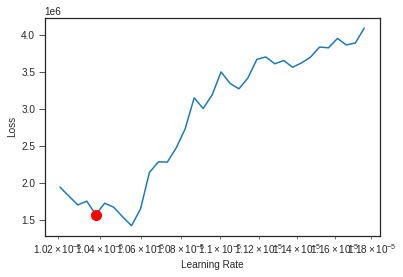

	 lr = 1.0381501298126917e-05



epoch      trn_loss   val_loss   
    0      213393766.285144 5196161.857546
    1      5242304.574311 1258712.144482
    2      2429555.271958 4861975.572814
    3      568306.820743 34.807905 
    4      9016221.436792 15631523.292666
    5      6087477.831811 7475704.712976
    6      2131263.297536 1929175.169341
    7      821.693112 12.272544 


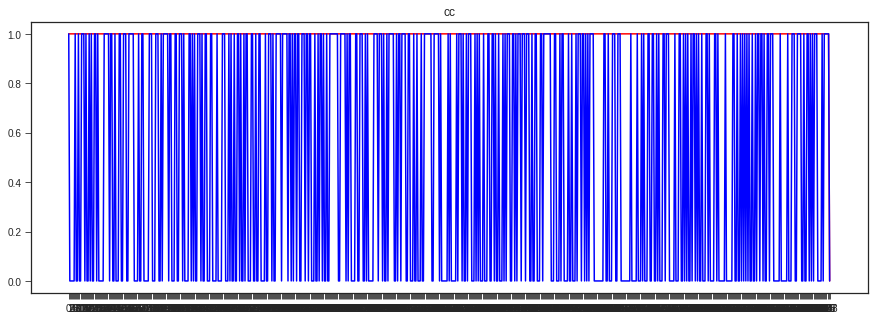

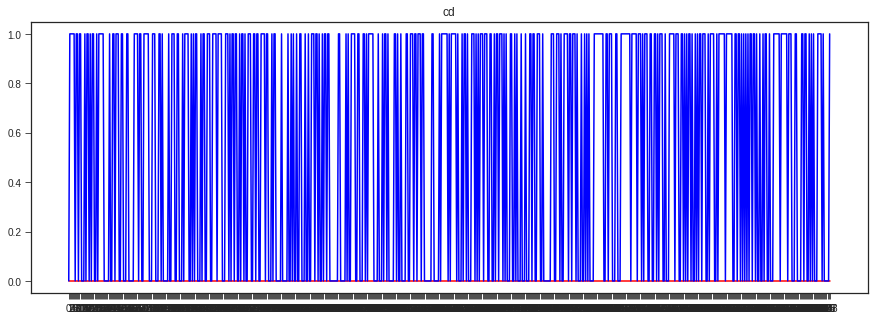

f1_score: 0.47249647390691113
accuracy_score: 0.47249647390691113
[[335   0]
 [374   0]]


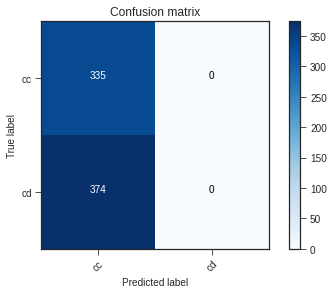

Deploying Model on Unclassified Samples /content/ADReSS-IS2020-data/test/Full_wave_enhanced_audio: 100%|██████████| 48/48 [00:01<00:00, 44.24it/s]
Deploying Model on Unclassified Samples /content/ADReSS-IS2020-data/test/Normalised_audio-chunks: 100%|██████████| 1243/1243 [00:26<00:00, 47.61it/s]


In [56]:
ZTM05(sample_rate_param, 
      downsampling_factors_param, 
      min_duration_param, 
      classes_param, 
      train_dirs_param,
      deploy_dirs_param,
      dataset_path_param,
      dataset_file_name_param,
      dataset_file_id_param,
      use_cuda_param,
      output_path_param,
      batch_sizes_param,
      learning_rates_param,
      cycles_param,
      cycle_lengths_param,
      result_filename_param,
      loss_function_param)